In [25]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

In [2]:
rawdata = pd.read_excel('Hallgatói adatok_eredeti.xlsx')

In [3]:
rawdata.head()

,azonosito,nem,allampolgarsag1,allampolgarsag2,szul_orszag,szul_kisterseg,szul_megye,szul_megye_id,szulev,kulfoldi,...,megye160501,mn1205,mn1211,mn1305,mn1311,mn1405,mn1411,mn1505,mn1511,mn1605
0,24,nõ,magyar,NaN,Magyarország,Békéscsabai,Békés,4.0,1980,N,...,1.0,0,0,0,0,0,0,0,0,0
1,63,nõ,magyar,NaN,Magyarország,Gyõri,Gyõr-Moson-Sopron,8.0,1990,N,...,NaN,0,0,0,0,0,0,0,0,0
2,78,nõ,magyar,NaN,Magyarország,Budapesti,Budapest,1.0,1962,N,...,1.0,0,0,0,0,0,0,0,0,0
3,98,nõ,magyar,NaN,Magyarország,Nagyatádi,Somogy,14.0,1990,N,...,14.0,0,0,0,0,0,0,0,0,0
4,141,férfi,magyar,NaN,Magyarország,Budapesti,Budapest,1.0,1990,N,...,13.0,0,0,0,0,0,0,0,0,0


In [ ]:
#tevékenységi kód 
print(f"'{'tev120501'}':\n", rawdata['tev120501'].value_counts()) #77 kül.
#64.0: Pénzügyi közvetítés (kivéve: biztosítási, nyugdíjpénztári tevékenység)

In [ ]:
#foglalkozás kód 
print(f"'{'feor120501'}':\n", rawdata['feor120501'].value_counts()) #237 különböző

In [ ]:
print(f"'{'raw_data'}':\n", rawdata['nem'].value_counts())
#a sokaság több, mint 2/3-a nő (69.6%)

In [ ]:
print(f"'{'raw_data'}':\n", rawdata['szulev'].value_counts())
#nagyrészt a "frissen" érettségizettek, néhány idősebb
#1990,1989,1988,1991, a többi megfigyelt személy idősebb

In [4]:
fiatal = rawdata['szulev']<1988
fiatal

0        True
1       False
2        True
3       False
4       False
        ...  
8292    False
8293    False
8294    False
8295     True
8296     True
Name: szulev, Length: 8297, dtype: bool

In [ ]:
print(f"'{'allampolgarsag'}':\n", rawdata['allampolgarsag1'].value_counts())
#nagyrészt magyarok, néhány szomszédos ország és elenyésző egyéb országbeli
#counts = pd.value_counts(rawdata['allampolgarsag1'])
#mask = rawdata['allampolgarsag1'].isin(counts[counts > 23].index)
#pd.get_dummies(rawdata['allampolgarsag1'][mask])
#rawdata['kulfoldi']
#erre van a kulfoldi valtozó beépítve

In [5]:
munkanelkul1205= rawdata['mn1205']>0
#munkanelkul1205
# volt-e munkanélküli

In [ ]:
#Befolyásoló-e, hogy hova született valaki?
print(f"'{'szul_megye'}':\n", rawdata['szul_megye'].value_counts())
print(f"'{'szul_kisterseg'}':\n", rawdata['szul_kisterseg'].value_counts()) #119 féle

In [6]:
nagyvarosi = rawdata['szul_kisterseg'].isin(['Budapesti','Debreceni','Miskolci','Pécsi','Győri'])
#nagyvarosi

In [7]:
data = [rawdata['kulfoldi'], fiatal,rawdata['nem'],munkanelkul1205,nagyvarosi] #,rawdata['egyetem_13']
headers = ["külföldi", "fiatal","nem","munkanélküli","nagyvarosi"] #,"egyetem_13"
df3 = pd. concat(data, axis=1, keys=headers)

In [8]:
df2=rawdata['jovedelem120501'].to_frame()

In [9]:
data = df2.join(pd.get_dummies(df3))

In [ ]:
data

In [13]:
#missing = data['munkanélküli'].isna().sum() #0
#missing = data['nagyvarosi'].isna().sum() #0
#missing = data['fiatal'].isna().sum() #0
#missing = data['külföldi_N'].isna().sum() #0
#missing

In [11]:
np.seterr(divide = 'ignore') 

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [12]:
data = [rawdata['kulfoldi'], fiatal,rawdata['nem'],munkanelkul1205,nagyvarosi] #,rawdata['egyetem_13']
headers = ["külföldi", "fiatal","nem","munkanélküli","nagyvarosi"] #,"egyetem_13"
df3 = pd. concat(data, axis=1, keys=headers)
df2=rawdata['jovedelem120501'].to_frame()
data = df2.join(pd.get_dummies(df3))
data = data.dropna(subset=['jovedelem120501'])
X = data[data.columns.difference(['jovedelem120501'])].dropna().values
m=data.dropna()['jovedelem120501']
y = np.log(m, out=np.zeros_like(m), where=(m!=0))

In [14]:
jovedelem='jovedelem120501'
data = data.dropna(subset=[jovedelem])
data

,jovedelem120501,fiatal,munkanélküli,nagyvarosi,külföldi_I,külföldi_N,nem_férfi,nem_nõ
0,610000.0,True,False,False,0,1,0,1
2,479999.0,True,False,True,0,1,0,1
5,68678.0,True,True,False,0,1,0,1
6,128000.0,True,False,True,0,1,0,1
8,253000.0,False,False,True,0,1,1,0
...,...,...,...,...,...,...,...,...
7571,140300.0,True,False,False,0,1,0,1
7577,216734.0,True,False,True,0,1,1,0
7581,248000.0,True,False,True,0,1,1,0
7586,339999.0,True,False,False,0,1,1,0


Text(0.5, 0, 'Fizetések logaritmusa 2012-ben')

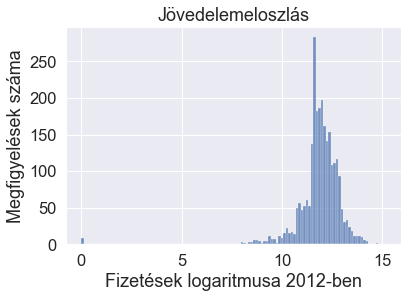

In [15]:
sns.set(font_scale=1.5)
plt.figure(figsize=(6,4))
plt.title('Jövedelemeloszlás')
sns.histplot(x=y, data = data)
plt.ylabel("Megfigyelések száma")
plt.xlabel("Fizetések logaritmusa 2012-ben")

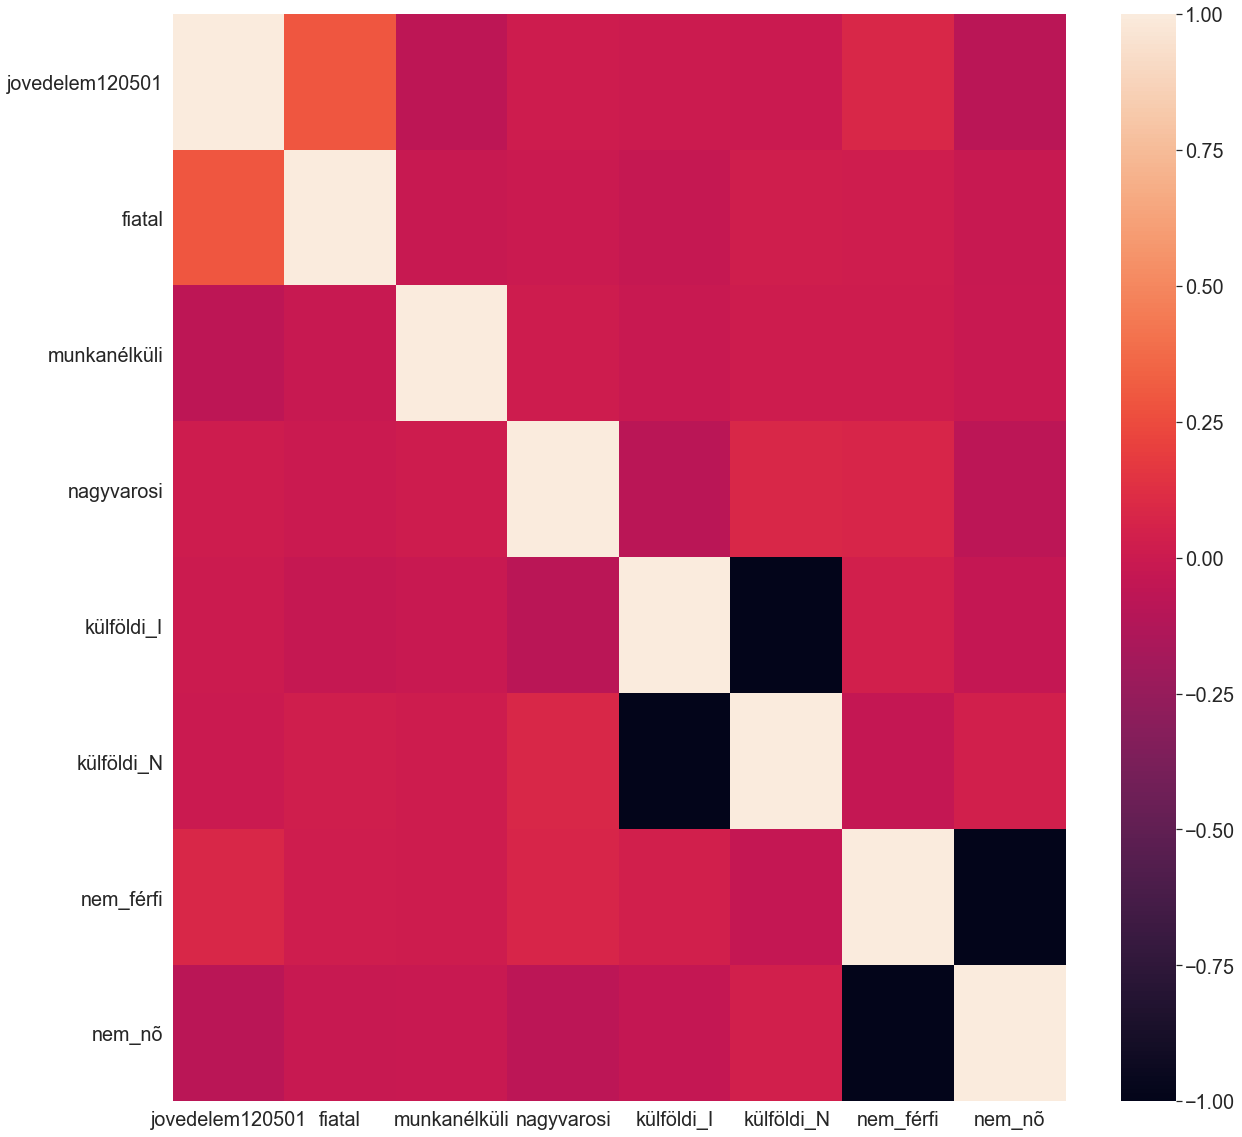

In [16]:
sns.set(font_scale=1.8)
%matplotlib inline

corr = data.corr()

plt.figure(figsize = (20,20))

# plot the heatmap
ax = sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

#a férfi nem és a "nem frissen érettségizettek" korrerál jobban a jövedelemmel

# Bevezető

In [ ]:
#csak tesztelésre egy sima regresszió
classic_regression = LinearRegression().fit(X, y)
classic_regression.score(X,y)

Definiálok egy függvényt, amely kiad egy teszt és train adatsort, az adat mellett és egy sima lin. regresszó eredményt
a beadott változókhoz: magyarázó változó táblához és adott fizetéshez

In [17]:
def linreg_dfs(df3,jovedelem): 
    df2=rawdata[jovedelem].to_frame()
    data = df2.join(pd.get_dummies(df3))
    data = data.dropna(subset=[jovedelem])
    X = data[data.columns.difference([jovedelem])].dropna().values
    m=data.dropna()[jovedelem]
    y = np.log(m, out=np.zeros_like(m), where=(m!=0))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/4, random_state = 42)

    classic_regression = LinearRegression().fit(X, y)
    return classic_regression.score(X,y), X_train, X_test, y_train, y_test, data
#listaként adja ki az adatot

Egyetemmel

In [ ]:
data = [rawdata['kulfoldi'], fiatal,rawdata['nem'],munkanelkul1205,nagyvarosi,rawdata['egyetem_13']]
headers = ["külföldi", "fiatal","nem","munkanélküli","nagyvarosi","egyetem_13"]
df3 = pd. concat(data, axis=1,keys=headers)
score,X_train, X_test, y_train, y_test, data=linreg_dfs(df3,'jovedelem120501')
score

In [ ]:
%%time

reg = CatBoostRegressor(random_state=0, learning_rate=0.01,
                        depth=None,)
reg.fit(X_train, y_train)
reg.score(X_train, y_train), reg.score(X_test, y_test)

Megye, ahol dolgozik

In [ ]:
data = [rawdata['kulfoldi'], fiatal,rawdata['nem'],munkanelkul1205,nagyvarosi,pd.get_dummies(rawdata['megye120501'])]
headers = ["külföldi", "fiatal","nem","munkanélküli","nagyvarosi","megye120501"]
df3 = pd. concat(data, axis=1,keys=headers)
score,X_train, X_test, y_train, y_test, data=linreg_dfs(df3,'jovedelem120501')
score

In [ ]:
%%time

reg = CatBoostRegressor(random_state=0, learning_rate=0.01,
                        depth=None,)
reg.fit(X_train, y_train)
reg.score(X_train, y_train), reg.score(X_test, y_test)

Szakkal

In [ ]:
data = [rawdata['kulfoldi'], fiatal,rawdata['nem'],munkanelkul1205,nagyvarosi,rawdata['szak_13'],pd.get_dummies(rawdata['megye120501'])]
headers = ["külföldi", "fiatal","nem","munkanélküli","nagyvarosi","szak_13","megye120501"]
df3 = pd. concat(data, axis=1,keys=headers)
score,X_train, X_test, y_train, y_test, data=linreg_dfs(df3,'jovedelem120501')
score

Tevékenységgel

In [ ]:
data = [rawdata['kulfoldi'], fiatal,rawdata['nem'],munkanelkul1205,nagyvarosi,rawdata['szak_13'],pd.get_dummies(rawdata['megye120501']),pd.get_dummies(rawdata['tev120501'])]
headers = ["külföldi", "fiatal","nem","munkanélküli","nagyvarosi","szak_13","megye120501","tev12"]
df3 = pd. concat(data, axis=1,keys=headers)
score,X_train, X_test, y_train, y_test, data=linreg_dfs(df3,'jovedelem120501')
score

# A 2012-es jövedelem elemzés

Kimenettel, munkarenddel

In [18]:
data = [rawdata['kulfoldi'], fiatal,rawdata['nem'],munkanelkul1205,nagyvarosi,rawdata['szak_13'],pd.get_dummies(rawdata['megye120501']),pd.get_dummies(rawdata['tev120501']),pd.get_dummies(rawdata['kimenet_13']),pd.get_dummies(rawdata['munkarend_13'])]
headers = ["külföldi", "fiatal","nem","munkanélküli","nagyvarosi","szak_13","megye120501","tev12","kimenet","munkarend"]
        
df3 = pd. concat(data, axis=1,keys=headers)
score,X_train, X_test, y_train, y_test, data=linreg_dfs(df3,'jovedelem120501')
score
#122 magyarázó változó

0.3236790429293218

In [19]:
import warnings
warnings.filterwarnings("ignore")

pipe = make_pipeline(StandardScaler(), LinearRegression())
scaled_reg = pipe.fit(X_train, y_train) 

lasso = Lasso(alpha=1.0)
lasso.fit(X_train, y_train) 
print('Train: ', lasso.score(X_train, y_train))
print('Test: ', lasso.score(X_test, y_test))

for i in [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]:
    lasso = Lasso(alpha=i)
    lasso.fit(X_train, y_train)
    lasso_pipe = make_pipeline(StandardScaler(), Lasso(alpha=i))
    lasso_pipe.fit(X_train, y_train) 
    print('Alpha is ', i)
    print('Train - raw: ', lasso.score(X_train, y_train), ', scaled: ', lasso_pipe.score(X_train, y_train))
    print('Test - raw: : ', lasso.score(X_test, y_test), ', scaled: ', lasso_pipe.score(X_test, y_test))
    print('--------------')
    

Train:  0.0
Test:  -0.01790875621716581
Alpha is  1e-05
Train - raw:  0.3080771026902984 , scaled:  0.3080792239057618
Test - raw: :  0.3413466577778047 , scaled:  0.3409133332983899
--------------
Alpha is  0.0001
Train - raw:  0.307892412298154 , scaled:  0.3080783967087959
Test - raw: :  0.3445873786496224 , scaled:  0.3412327461683492
--------------
Alpha is  0.001
Train - raw:  0.29894518836369055 , scaled:  0.30799786054466227
Test - raw: :  0.3640917224931115 , scaled:  0.34408129507310126
--------------
Alpha is  0.01
Train - raw:  0.2210116712384833 , scaled:  0.3021148587432484
Test - raw: :  0.35726846315450334 , scaled:  0.36247439672491144
--------------
Alpha is  0.1
Train - raw:  0.10435996235666811 , scaled:  0.1904907552709375
Test - raw: :  0.16633589903839952 , scaled:  0.2937678475168901
--------------
Alpha is  1
Train - raw:  0.0 , scaled:  0.0
Test - raw: :  -0.01790875621716581 , scaled:  -0.01790875621716581
--------------
Alpha is  10
Train - raw:  0.0 , scale

In [20]:
#muszáj újra a data-t dataframeként megalkotni

jovedelem='jovedelem120501'
df2=rawdata[jovedelem].to_frame()
data = df2.join(pd.get_dummies(df3))
data = data.dropna(subset=[jovedelem])
X = data[data.columns.difference([jovedelem])].dropna().values
m=data.dropna()[jovedelem]
y = np.log(m, out=np.zeros_like(m), where=(m!=0))

In [21]:
lasso_pipe = make_pipeline(StandardScaler(), Lasso(alpha=0.001))
lasso_pipe.fit(X_train, y_train) 
print('Train: ', lasso_pipe.score(X_train, y_train))
print('Test: ', lasso_pipe.score(X_test, y_test))

Train:  0.30799786054466227
Test:  0.34408129507310126


In [22]:
best_lasso = make_pipeline(StandardScaler(), Lasso(alpha=0.01))
best_lasso.fit(X, y)
lasso_results = pd.DataFrame(data.columns[1:], best_lasso.named_steps['lasso'].coef_).reset_index()
lasso_results.columns=['coef', 'var']

Text(0.5, 1.0, 'Legfontosabb változók a Lasso modell szerint')

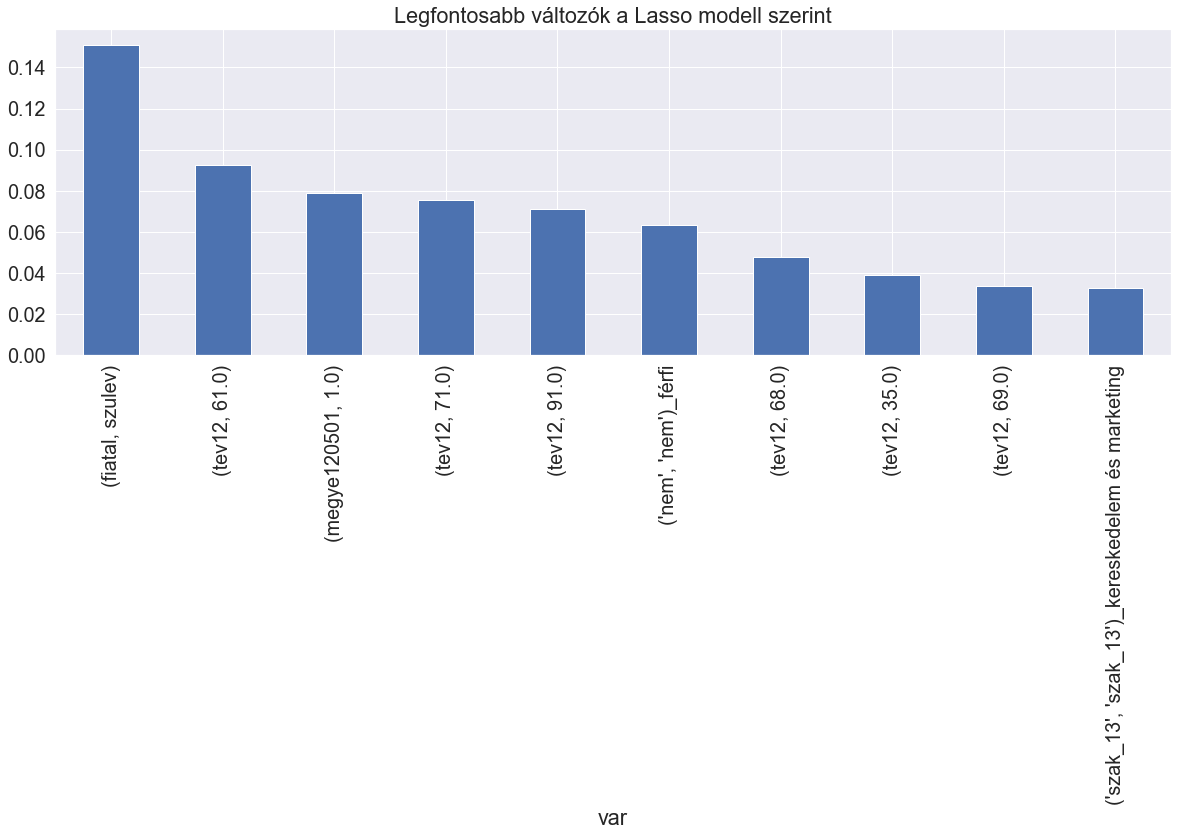

In [23]:
lasso_results.set_index('var')['coef'].nlargest(10).plot(kind='bar', figsize=(20,6))
plt.title('Legfontosabb változók a Lasso modell szerint')

# Döntési fa

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

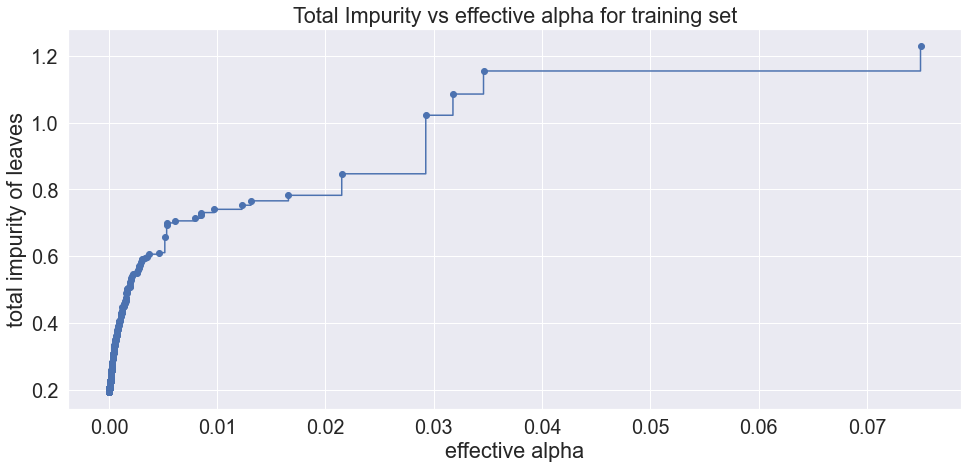

In [26]:
reg = DecisionTreeRegressor(random_state=0)
reg.fit(X_train, y_train)
reg.score(X_train, y_train), reg.score(X_test, y_test)
path = reg.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
fig, ax = plt.subplots(figsize=(16,7))
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [27]:
regs = []
for ccp_alpha in ccp_alphas:
    reg = DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)
    reg.fit(X_train, y_train)
    regs.append(reg)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      regs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.18690808736415132


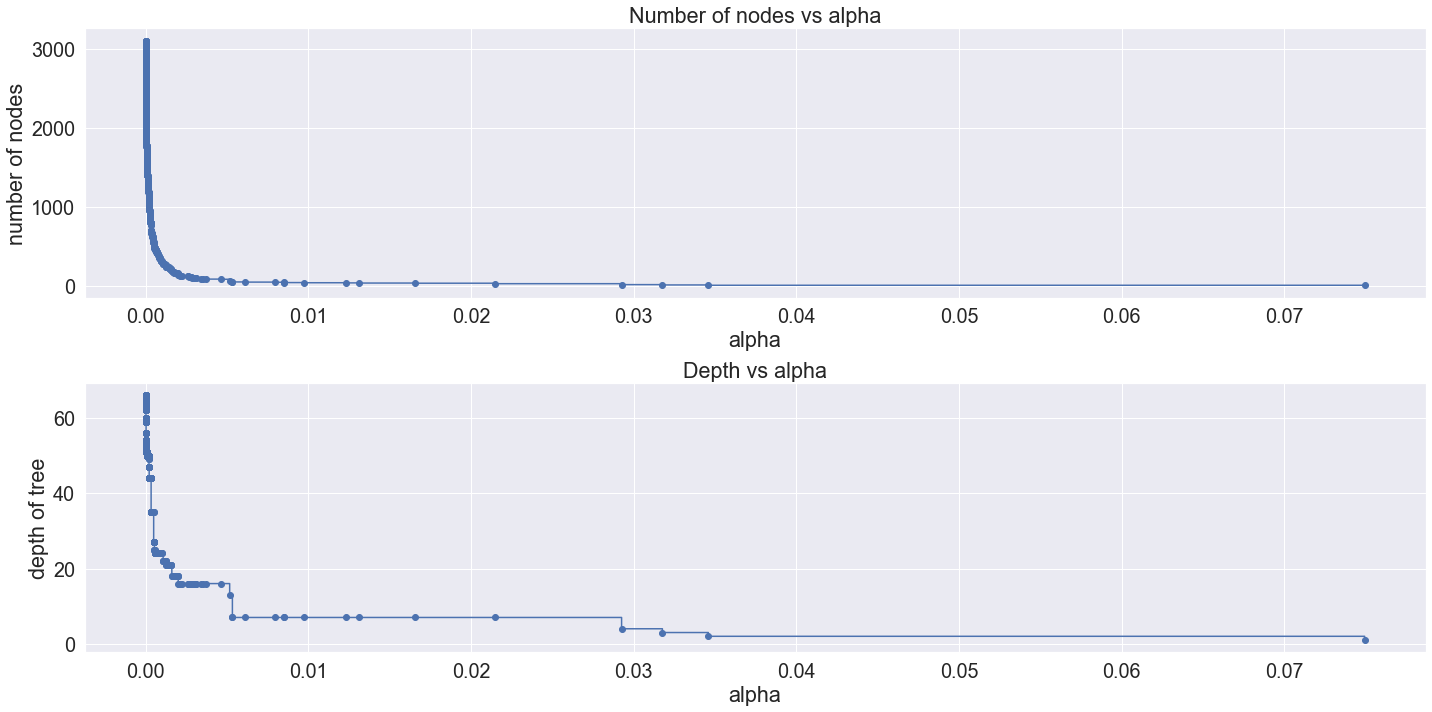

In [28]:
regs = regs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [reg.tree_.node_count for reg in regs]
depth = [reg.tree_.max_depth for reg in regs]
fig, ax = plt.subplots(2, 1, figsize=(20,10))
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()


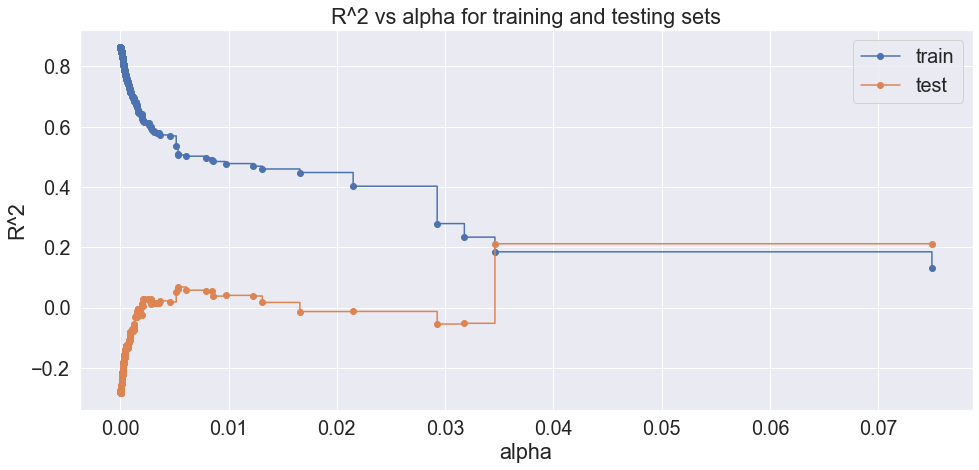

In [29]:
train_scores = [reg.score(X_train, y_train) for reg in regs]
test_scores = [reg.score(X_test, y_test) for reg in regs]

fig, ax = plt.subplots(figsize=(16,7))
ax.set_xlabel("alpha")
ax.set_ylabel("R^2")
ax.set_title("R^2 vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [30]:
max(test_scores)

0.2116203412074441

In [31]:

reg = DecisionTreeRegressor(random_state=0,ccp_alpha=0.035)
reg.fit(X_train, y_train)
reg.score(X_train, y_train), reg.score(X_test, y_test)

(0.18479494655909845, 0.2116203412074441)

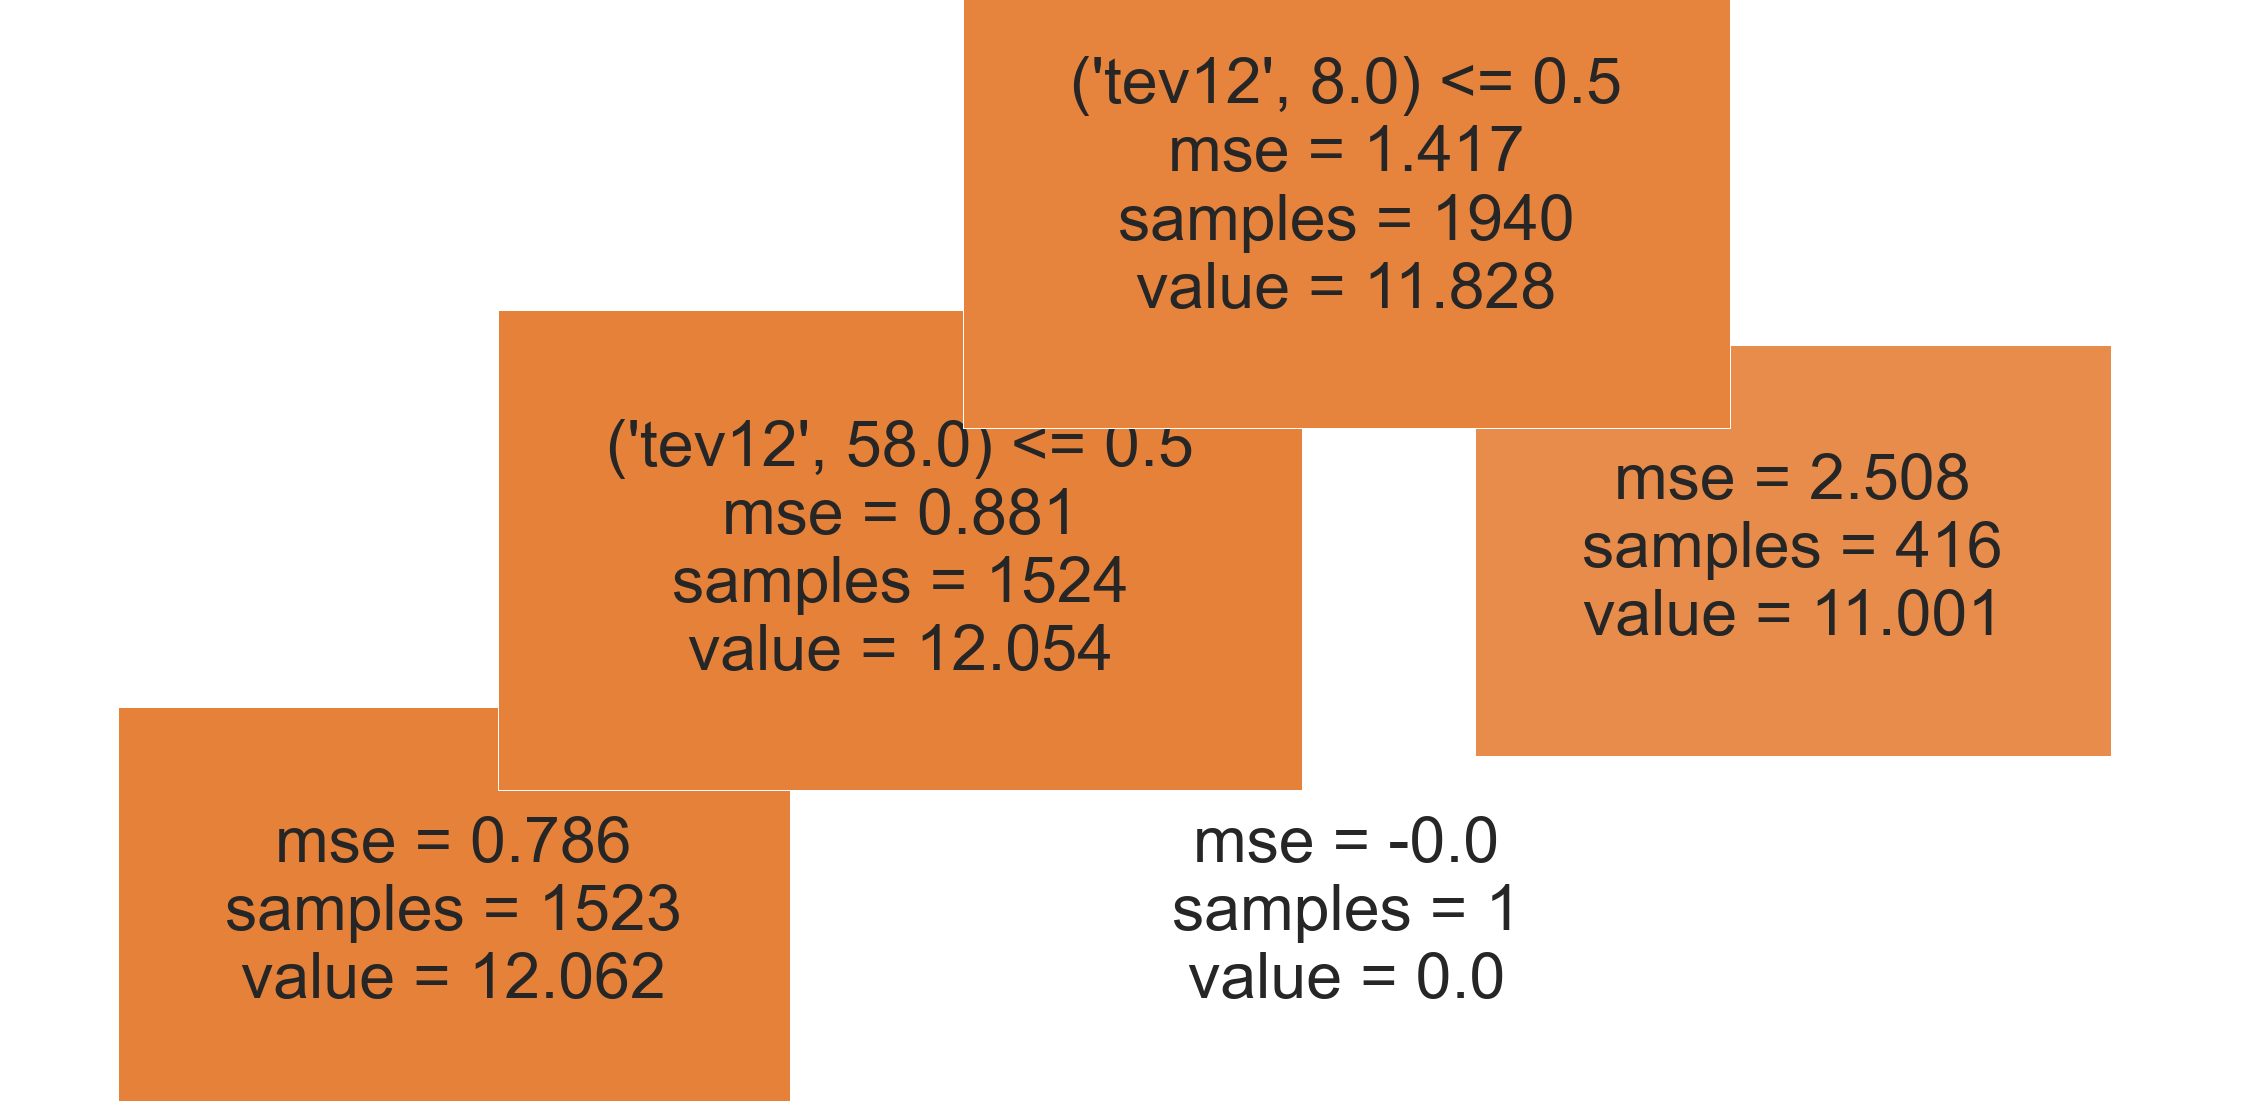

In [32]:

sns.set(font_scale=0.2)
plt.figure(figsize=(40,20))  # customize according to the size of your tree
_ = tree.plot_tree(reg, feature_names = data.columns, filled=True)
plt.show()

# Boosting

GridSearchCV

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
reg = GradientBoostingRegressor(random_state=0, n_estimators=200)
reg.fit(X_train, y_train)
reg.score(X_train, y_train), reg.score(X_test, y_test)

In [ ]:
parameters = {
    "learning_rate": [0.05, 0.075, 0.1, 0.125, 0.15],
    "min_samples_split": [2, 4, 8, 12, 16],
    "random_state": [42],
    "subsample":[0.6, 0.7, 0.8, 0.9, 1.0],
    "n_estimators":[200]
    }

reg_search = GridSearchCV(GradientBoostingRegressor(), parameters, verbose=10, cv=3)
reg_search.fit(X_train, y_train) 

In [ ]:
print("Best parameters set found on development set:")
print(reg_search.best_params_)

In [ ]:
print('Test score:', reg_search.score(X_test, y_test))

In [ ]:
parameters = {
    "learning_rate": [0.01,0.05, 0.1],
    "random_state": [42],
    "subsample":[0.5, 0.75],
    "n_estimators":[200],
    "depth":[5,6,7]
    }

reg_search = GridSearchCV(CatBoostRegressor(), parameters, verbose=10, cv=3)
reg_search.fit(X_train, y_train) 

In [ ]:
print("Best parameters set found on development set:")
print(reg_search.best_params_)

In [ ]:
print('Test score:', reg_search.score(X_test, y_test))

In [ ]:
imp_df = pd.DataFrame(reg.feature_importances_, data.columns.difference(['jovedelem120501'])).reset_index()
imp_df.columns = ['Feature', 'Importance']

In [ ]:
imp_df.sort_values('Importance', ascending=False).set_index('Feature').head(10).plot(kind='bar', figsize=(16,6))

In [33]:
CatBoost "original"

SyntaxError: invalid syntax (<ipython-input-33-33484ff7713e>, line 1)

In [ ]:
%%time
#CatBoost:
reg = CatBoostRegressor(random_state=0, learning_rate=0.01,
                        depth=None,)
reg.fit(X_train, y_train)
reg.score(X_train, y_train), reg.score(X_test, y_test)

In [ ]:
print(reg.get_all_params())

In [ ]:

imp_df = pd.DataFrame(reg.feature_importances_, data.columns.difference(['jovedelem120501'])).reset_index()
imp_df.columns = ['Feature', 'Importance']

imp_df.sort_values('Importance', ascending=False).set_index('Feature').head(10).plot(kind='bar', figsize=(16,6))
plt.title('Változók fontossága (CatBoost)')

In [ ]:
data

In [ ]:
#from catboost import CatBoostClassifier, Pool
#reg.plot_tree(200, pool=None)
#AttributeError: module 'graphviz.backend' has no attribute 'ENCODING'

In [ ]:
%%time
model = xgb.XGBRegressor(random_state=0)

# Fit model

model.fit(X_train, y_train)
model.score(X_train, y_train), model.score(X_test, y_test)

# 4 évvel később

Tevékenység https://www.ksh.hu/docs/osztalyozasok/teaor/teaor08_struktura_2018_08_01.pdf

Új változóként megjelenik a második képzés is

In [39]:
rawdata['tanultovabb']=-rawdata['kimenet_15'].isna()
#rawdata['tanultovabb']

In [40]:
data = [rawdata['kulfoldi'], fiatal,rawdata['nem'],munkanelkul1205,nagyvarosi,rawdata['szak_13'],pd.get_dummies(rawdata['megye120501']),pd.get_dummies(rawdata['tev120501']),pd.get_dummies(rawdata['kimenet_13']),pd.get_dummies(rawdata['munkarend_13'])]
headers = ["külföldi", "fiatal","nem","munkanélküli","nagyvarosi","szak_13","megye120501","tev12","kimenet","munkarend"]

In [41]:
munkanelkul1605= rawdata['mn1205']>0

data = [rawdata['kulfoldi'], fiatal,rawdata['nem'],munkanelkul1605,nagyvarosi,pd.get_dummies(rawdata['kepzterulet_15']),pd.get_dummies(rawdata['megye160501']),pd.get_dummies(rawdata['tev160501']),pd.get_dummies(rawdata['tanultovabb']),pd.get_dummies(rawdata['kimenet_15']),pd.get_dummies(rawdata['munkarend_15']),rawdata['szint_15']]
headers = ["külföldi", "fiatal","nem","munkanélküli","nagyvarosi","kepzes_15","megye","tev","tovabb","kimenet","munkarend","szint"]
df3 = pd. concat(data, axis=1,keys=headers)

score,X_train, X_test, y_train, y_test, data=linreg_dfs(df3,'jovedelem160501')
score

0.16131186632372885

In [42]:
jovedelem='jovedelem160501'
df2=rawdata[jovedelem].to_frame()
data = df2.join(pd.get_dummies(df3))
data = data.dropna(subset=[jovedelem])
X = data[data.columns.difference([jovedelem])].dropna().values
m=data.dropna()[jovedelem]
y = np.log(m, out=np.zeros_like(m), where=(m!=0))

# Lasso

In [43]:
lasso_pipe = make_pipeline(StandardScaler(), Lasso(alpha=0.001))
lasso_pipe.fit(X_train, y_train) 
print('Train: ', lasso_pipe.score(X_train, y_train))
print('Test: ', lasso_pipe.score(X_test, y_test))

Train:  0.15975467753124684
Test:  0.13752097598538437


In [44]:
best_lasso = make_pipeline(StandardScaler(), Lasso(alpha=0.01))
best_lasso.fit(X, y)
lasso_results = pd.DataFrame(data.columns[1:], best_lasso.named_steps['lasso'].coef_).reset_index()
lasso_results.columns=['coef', 'var']

Text(0.5, 1.0, 'Legfontosabb változók a Lasso modell szerint')

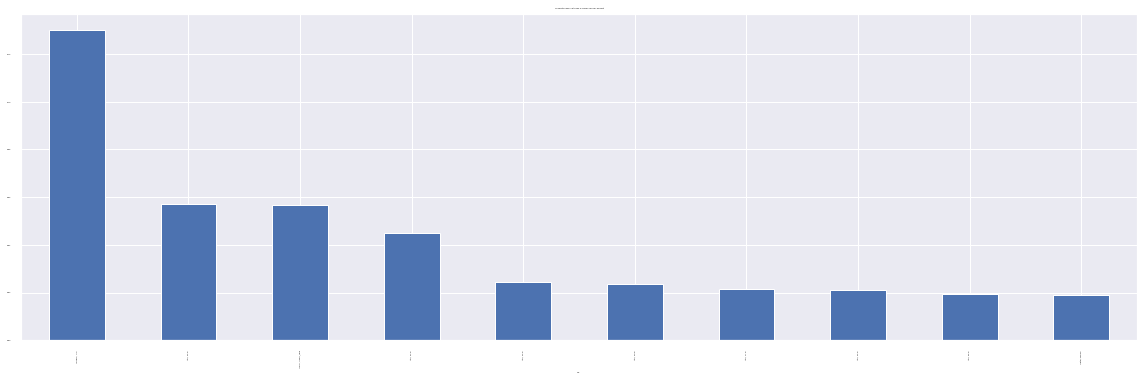

In [45]:
lasso_results.set_index('var')['coef'].nlargest(10).plot(kind='bar', figsize=(20,6))
plt.title('Legfontosabb változók a Lasso modell szerint')

In [35]:
#data.to_csv('data_test2.csv', index=False)

In [46]:
%%time

model = xgb.XGBRegressor(random_state=0,max_depth=3, learning_rate=0.3)
model.fit(X_train, y_train)
test_pred = model.predict(X_test)
model.score(X_train, y_train), model.score(X_test, y_test)

Wall time: 1.02 s


(0.3676515920127936, 0.17206402463686)

Most a sima XGBoost jobban teljesít a teszt adatokon

In [47]:
%%time
reg = CatBoostRegressor(random_state=0, learning_rate=0.01,
                        depth=None,)
reg.fit(X_train, y_train)
reg.score(X_train, y_train), reg.score(X_test, y_test)

0:	learn: 0.8274185	total: 3.21ms	remaining: 3.21s
1:	learn: 0.8268109	total: 6.43ms	remaining: 3.21s
2:	learn: 0.8261973	total: 9.45ms	remaining: 3.14s
3:	learn: 0.8256230	total: 12.5ms	remaining: 3.12s
4:	learn: 0.8250572	total: 15.5ms	remaining: 3.09s
5:	learn: 0.8245038	total: 18.5ms	remaining: 3.07s
6:	learn: 0.8239686	total: 21.5ms	remaining: 3.05s
7:	learn: 0.8233428	total: 24.5ms	remaining: 3.04s
8:	learn: 0.8230260	total: 27.4ms	remaining: 3.02s
9:	learn: 0.8225400	total: 30.5ms	remaining: 3.02s
10:	learn: 0.8219406	total: 33.5ms	remaining: 3.01s
11:	learn: 0.8213941	total: 36.4ms	remaining: 3s
12:	learn: 0.8209806	total: 39.8ms	remaining: 3.02s
13:	learn: 0.8205610	total: 44.1ms	remaining: 3.1s
14:	learn: 0.8199796	total: 47.1ms	remaining: 3.09s
15:	learn: 0.8194354	total: 50ms	remaining: 3.07s
16:	learn: 0.8189116	total: 52.9ms	remaining: 3.06s
17:	learn: 0.8183648	total: 56ms	remaining: 3.05s
18:	learn: 0.8180369	total: 59.1ms	remaining: 3.05s
19:	learn: 0.8175267	total: 62

183:	learn: 0.7744373	total: 554ms	remaining: 2.46s
184:	learn: 0.7742526	total: 558ms	remaining: 2.46s
185:	learn: 0.7741442	total: 561ms	remaining: 2.45s
186:	learn: 0.7739573	total: 564ms	remaining: 2.45s
187:	learn: 0.7737563	total: 567ms	remaining: 2.45s
188:	learn: 0.7736723	total: 570ms	remaining: 2.45s
189:	learn: 0.7734529	total: 573ms	remaining: 2.44s
190:	learn: 0.7733567	total: 577ms	remaining: 2.44s
191:	learn: 0.7731676	total: 580ms	remaining: 2.44s
192:	learn: 0.7728867	total: 584ms	remaining: 2.44s
193:	learn: 0.7727177	total: 587ms	remaining: 2.44s
194:	learn: 0.7724309	total: 590ms	remaining: 2.43s
195:	learn: 0.7722840	total: 593ms	remaining: 2.43s
196:	learn: 0.7721949	total: 596ms	remaining: 2.43s
197:	learn: 0.7720291	total: 599ms	remaining: 2.43s
198:	learn: 0.7719282	total: 602ms	remaining: 2.42s
199:	learn: 0.7717591	total: 605ms	remaining: 2.42s
200:	learn: 0.7716415	total: 608ms	remaining: 2.42s
201:	learn: 0.7714560	total: 611ms	remaining: 2.42s
202:	learn: 

349:	learn: 0.7512461	total: 1.1s	remaining: 2.05s
350:	learn: 0.7510842	total: 1.11s	remaining: 2.05s
351:	learn: 0.7508661	total: 1.11s	remaining: 2.04s
352:	learn: 0.7507865	total: 1.11s	remaining: 2.04s
353:	learn: 0.7505992	total: 1.12s	remaining: 2.04s
354:	learn: 0.7504180	total: 1.12s	remaining: 2.04s
355:	learn: 0.7502936	total: 1.12s	remaining: 2.03s
356:	learn: 0.7502256	total: 1.13s	remaining: 2.03s
357:	learn: 0.7501436	total: 1.13s	remaining: 2.02s
358:	learn: 0.7500864	total: 1.13s	remaining: 2.02s
359:	learn: 0.7500499	total: 1.14s	remaining: 2.02s
360:	learn: 0.7498354	total: 1.14s	remaining: 2.02s
361:	learn: 0.7497693	total: 1.14s	remaining: 2.01s
362:	learn: 0.7496876	total: 1.15s	remaining: 2.01s
363:	learn: 0.7495871	total: 1.15s	remaining: 2.01s
364:	learn: 0.7495530	total: 1.15s	remaining: 2s
365:	learn: 0.7494134	total: 1.16s	remaining: 2s
366:	learn: 0.7492652	total: 1.16s	remaining: 2s
367:	learn: 0.7491123	total: 1.16s	remaining: 1.99s
368:	learn: 0.7489955	

524:	learn: 0.7352628	total: 1.66s	remaining: 1.5s
525:	learn: 0.7351305	total: 1.66s	remaining: 1.5s
526:	learn: 0.7350263	total: 1.67s	remaining: 1.5s
527:	learn: 0.7349690	total: 1.67s	remaining: 1.49s
528:	learn: 0.7348621	total: 1.67s	remaining: 1.49s
529:	learn: 0.7348025	total: 1.68s	remaining: 1.49s
530:	learn: 0.7347653	total: 1.68s	remaining: 1.48s
531:	learn: 0.7346305	total: 1.68s	remaining: 1.48s
532:	learn: 0.7344997	total: 1.69s	remaining: 1.48s
533:	learn: 0.7343964	total: 1.69s	remaining: 1.47s
534:	learn: 0.7342794	total: 1.69s	remaining: 1.47s
535:	learn: 0.7342315	total: 1.7s	remaining: 1.47s
536:	learn: 0.7341637	total: 1.7s	remaining: 1.46s
537:	learn: 0.7340805	total: 1.7s	remaining: 1.46s
538:	learn: 0.7340350	total: 1.71s	remaining: 1.46s
539:	learn: 0.7340045	total: 1.71s	remaining: 1.46s
540:	learn: 0.7339402	total: 1.71s	remaining: 1.45s
541:	learn: 0.7338601	total: 1.71s	remaining: 1.45s
542:	learn: 0.7337065	total: 1.72s	remaining: 1.45s
543:	learn: 0.7335

690:	learn: 0.7214682	total: 2.21s	remaining: 988ms
691:	learn: 0.7213670	total: 2.21s	remaining: 985ms
692:	learn: 0.7212998	total: 2.21s	remaining: 982ms
693:	learn: 0.7212337	total: 2.22s	remaining: 978ms
694:	learn: 0.7211697	total: 2.22s	remaining: 975ms
695:	learn: 0.7210976	total: 2.22s	remaining: 972ms
696:	learn: 0.7209957	total: 2.23s	remaining: 969ms
697:	learn: 0.7209337	total: 2.23s	remaining: 965ms
698:	learn: 0.7208949	total: 2.23s	remaining: 962ms
699:	learn: 0.7208590	total: 2.24s	remaining: 959ms
700:	learn: 0.7208522	total: 2.24s	remaining: 955ms
701:	learn: 0.7207803	total: 2.24s	remaining: 952ms
702:	learn: 0.7206637	total: 2.25s	remaining: 949ms
703:	learn: 0.7206236	total: 2.25s	remaining: 946ms
704:	learn: 0.7205097	total: 2.25s	remaining: 943ms
705:	learn: 0.7203537	total: 2.25s	remaining: 939ms
706:	learn: 0.7203220	total: 2.26s	remaining: 936ms
707:	learn: 0.7202462	total: 2.26s	remaining: 933ms
708:	learn: 0.7201644	total: 2.27s	remaining: 930ms
709:	learn: 

867:	learn: 0.7089277	total: 2.76s	remaining: 419ms
868:	learn: 0.7088473	total: 2.76s	remaining: 416ms
869:	learn: 0.7087887	total: 2.76s	remaining: 413ms
870:	learn: 0.7087781	total: 2.77s	remaining: 410ms
871:	learn: 0.7087651	total: 2.77s	remaining: 407ms
872:	learn: 0.7087163	total: 2.77s	remaining: 404ms
873:	learn: 0.7086886	total: 2.78s	remaining: 400ms
874:	learn: 0.7086401	total: 2.78s	remaining: 397ms
875:	learn: 0.7085906	total: 2.79s	remaining: 394ms
876:	learn: 0.7085359	total: 2.79s	remaining: 391ms
877:	learn: 0.7084848	total: 2.79s	remaining: 388ms
878:	learn: 0.7083769	total: 2.8s	remaining: 385ms
879:	learn: 0.7083513	total: 2.8s	remaining: 382ms
880:	learn: 0.7083027	total: 2.8s	remaining: 378ms
881:	learn: 0.7082363	total: 2.8s	remaining: 375ms
882:	learn: 0.7082240	total: 2.81s	remaining: 372ms
883:	learn: 0.7081479	total: 2.81s	remaining: 369ms
884:	learn: 0.7080767	total: 2.81s	remaining: 366ms
885:	learn: 0.7079891	total: 2.82s	remaining: 362ms
886:	learn: 0.70

(0.2845239429628792, 0.12735565912229774)

Text(0.5, 1.0, 'Változók fontossága (CatBoost)')

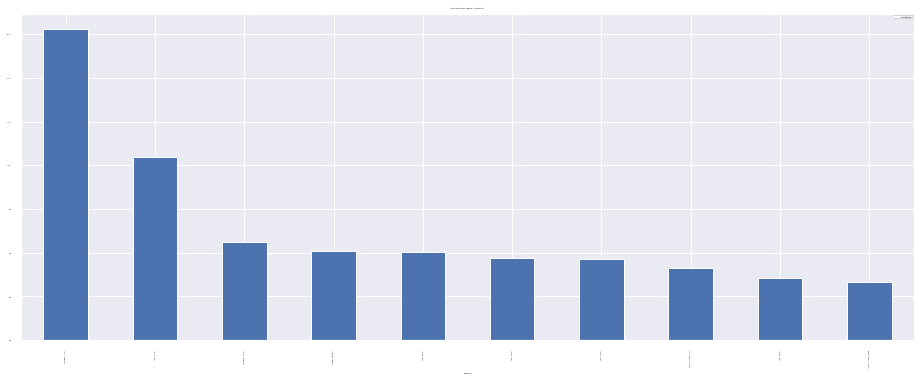

In [48]:

imp_df = pd.DataFrame(reg.feature_importances_, data.columns.difference(['jovedelem160501'])).reset_index()
imp_df.columns = ['Feature', 'Importance']

imp_df.sort_values('Importance', ascending=False).set_index('Feature').head(10).plot(kind='bar', figsize=(16,6))
plt.title('Változók fontossága (CatBoost)')

conda install python-graphviz